# Indicadores AH

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pyodbc
import string
import re

## Consideraciones
 - Servidor : BTBDMD00
 - BD : BD_DATASCIENCE
 - ##CICS_VIG_CFO Es el stock de los clientes (OOT VIGENTES CFO - BCP)
 - FECHAS : 6 MESES CERRADOS

In [2]:
# Conexion BTBDMD00

DMD = pyodbc.connect('''   Driver={SQL Server Native Client 11.0};
                            Server=BTBDMD00;
                            Database=BD_DATASCIENCE;
                            Trusted_Connection=yes;                 ''')
Q1=( '''
      SELECT CI_NIT_ORIGINANTE,FECHA,DWH_UNIV_ID,TITULAR_ORIGINANTE,CUENTA_ORIGEN,BANCO_DESTINO,IMPORTE_DOL,GLOSA=UPPER(GLOSA)
      FROM [BD_DATASCIENCE].[idm].[BASE_TRANSACCIONES_ACH]
      WHERE ESTADO_OPERACION in ('P','AB','C','T') AND 
            DWH_UNIV_ID in(SELECT DISTINCT DWH_CLI_CIC FROM ##CICS_VIG_CFO) AND  
            FECHA BETWEEN '20220101' AND '20220630'
     ''')

BD_ACH = pd.read_sql(Q1,DMD)
DMD.close()

BD_ACH.tail(2)

,CI_NIT_ORIGINANTE,FECHA,DWH_UNIV_ID,TITULAR_ORIGINANTE,CUENTA_ORIGEN,BANCO_DESTINO,IMPORTE_DOL,GLOSA
77622,01359855PO,20220511,00487331,OLGA ROMERO DURAN,30151075027319,BANCO UNION,174.93,BM PAG ALQ ABRIL
77623,03929929SC,20220511,00428701,CLAUDIA HAYDEE PACHECO AYALA,70150276391319,BANCO GANADERO,263.56,BM IMPUESTOS Y PAGO MES


In [3]:
measurer = np.vectorize(len)
res1 = measurer(BD_ACH[['BANCO_DESTINO']].values.astype(str)).max(axis=0)
res1

array([32])

In [4]:
# Agregando Columnas y Limpiando datos
BD_ACH=BD_ACH.dropna()
BD_ACH['PERIODO_VIG']='202206'
BD_ACH['GLOSA_FIN']=[re.sub("BM","", x) for x in BD_ACH['GLOSA']]
BD_ACH['GLOSA_FIN']=[re.sub("IA","", x) for x in BD_ACH['GLOSA_FIN']]
BD_ACH['GLOSA_FIN']=[re.sub("BL","", x) for x in BD_ACH['GLOSA_FIN']]
BD_ACH["AHORRO"]=BD_ACH['GLOSA_FIN'].str.contains('AHORRO', na=False)

BD_ACH.tail(2)

,CI_NIT_ORIGINANTE,FECHA,DWH_UNIV_ID,TITULAR_ORIGINANTE,CUENTA_ORIGEN,BANCO_DESTINO,IMPORTE_DOL,GLOSA,PERIODO_VIG,GLOSA_FIN,AHORRO
77622,01359855PO,20220511,00487331,OLGA ROMERO DURAN,30151075027319,BANCO UNION,174.93,BM PAG ALQ ABRIL,202206,PAG ALQ ABRIL,False
77623,03929929SC,20220511,00428701,CLAUDIA HAYDEE PACHECO AYALA,70150276391319,BANCO GANADERO,263.56,BM IMPUESTOS Y PAGO MES,202206,IMPUESTOS Y PAGO MES,False


## Indicadores Poblacionales

In [5]:
INDICADORES_2=BD_ACH.groupby(['DWH_UNIV_ID','PERIODO_VIG'])['BANCO_DESTINO'].agg({lambda x: x.value_counts().index[0]}).reset_index()
INDICADORES_2=INDICADORES_2.rename(columns={"DWH_UNIV_ID": "DWH_UNIV_ID", "PERIODO_VIG": "PERIODO_VIG","<lambda>":"BANCO_DESTINO"})
bd_aux=BD_ACH.merge(INDICADORES_2,how='inner',on=['DWH_UNIV_ID','PERIODO_VIG','BANCO_DESTINO'])
bd_aux.groupby(['DWH_UNIV_ID','PERIODO_VIG','BANCO_DESTINO'])['CI_NIT_ORIGINANTE'].count().reset_index()

,DWH_UNIV_ID,PERIODO_VIG,BANCO_DESTINO,CI_NIT_ORIGINANTE
0,00001574,202206,BANCO BISA,3
1,00001844,202206,BANCO UNION,12
2,00002625,202206,BANCO NACIONAL DE BOLIVIA,12
3,00003057,202206,BANCO MERCANTIL,7
4,00003325,202206,BANCO BISA,16
5,00003368,202206,BANCO BISA,15
6,00004051,202206,BANCO BISA,8
7,00004248,202206,BANCO NACIONAL DE BOLIVIA,3
8,00004531,202206,BANCO SOL,5
9,00004911,202206,BANCO MERCANTIL,8


In [6]:
# Indicadores Montos generales
INDICADORES_MONTOS=BD_ACH.groupby(['DWH_UNIV_ID','PERIODO_VIG'])['IMPORTE_DOL'].agg({'PROP_ACH_AVG_IMPORTE':'mean','PROP_ACH_MED_IMPORTE':'median','PROP_ACH_STP_IMPORTE':'std', 'PROP_ACH_TOT_IMPORTE':'sum','PROP_FREC_OPER':'count'}).reset_index()
INDICADORES_2=BD_ACH.groupby(['DWH_UNIV_ID','PERIODO_VIG'])['BANCO_DESTINO'].agg({lambda x: x.value_counts().index[0]}).reset_index()
INDICADORES_2=INDICADORES_2.rename(columns={"DWH_UNIV_ID": "DWH_UNIV_ID", "PERIODO_VIG": "PERIODO_VIG","<lambda>":"BANCO_DESTINO"})
bd_aux=BD_ACH.merge(INDICADORES_2,how='inner',on=['DWH_UNIV_ID','PERIODO_VIG','BANCO_DESTINO'])
bd_aux=bd_aux.groupby(['DWH_UNIV_ID','PERIODO_VIG'])['BANCO_DESTINO'].count().reset_index()
bd_aux=bd_aux.rename(columns={"DWH_UNIV_ID":"DWH_UNIV_ID","PERIODO_VIG":"PERIODO_VIG","BANCO_DESTINO":"PROP_ACH_MODA_FREC_BANCO_GEN"})
INDICADORES_2=INDICADORES_2.rename(columns={"DWH_UNIV_ID": "DWH_UNIV_ID", "PERIODO_VIG": "PERIODO_VIG","BANCO_DESTINO":"PROP_ACH_BANCO_DESTINO"})
INDICADORES_MONTOS=INDICADORES_MONTOS.merge(INDICADORES_2,how='inner',on=['DWH_UNIV_ID', 'PERIODO_VIG'])
INDICADORES_MONTOS=INDICADORES_MONTOS.merge(bd_aux,how='inner',on=['DWH_UNIV_ID', 'PERIODO_VIG'])
INDICADORES_MONTOS

,DWH_UNIV_ID,PERIODO_VIG,PROP_ACH_AVG_IMPORTE,PROP_ACH_MED_IMPORTE,PROP_ACH_STP_IMPORTE,PROP_ACH_TOT_IMPORTE,PROP_FREC_OPER,PROP_ACH_BANCO_DESTINO,PROP_ACH_MODA_FREC_BANCO_GEN
0,00001574,202206,43.400000,21.870,49.761743,303.80,7,BANCO BISA,3
1,00001844,202206,29.195143,27.480,17.479705,1021.83,35,BANCO UNION,12
2,00002625,202206,77.806667,78.060,24.943653,933.68,12,BANCO NACIONAL DE BOLIVIA,12
3,00003057,202206,150.311111,218.660,109.058943,1352.80,9,BANCO MERCANTIL,7
4,00003325,202206,264.447407,218.660,273.273773,7140.08,27,BANCO BISA,16
5,00003368,202206,71.547333,61.530,47.127576,2146.42,30,BANCO BISA,15
6,00004051,202206,253.408750,375.660,169.056383,2027.27,8,BANCO BISA,8
7,00004248,202206,139.630000,78.720,159.163602,1535.93,11,BANCO NACIONAL DE BOLIVIA,3
8,00004531,202206,255.537143,72.890,482.640938,1788.76,7,BANCO SOL,5
9,00004911,202206,91.011818,47.375,104.814755,2002.26,22,BANCO MERCANTIL,8


### Indicadores Mayores a 1000 DOLARES

In [8]:
# Indicadores Montos Filtrados 1000$
INDICADORES_MONTOS_1000=BD_ACH[BD_ACH['IMPORTE_DOL']>=1000].groupby(['DWH_UNIV_ID','PERIODO_VIG'])['IMPORTE_DOL'].agg({'PROP_ACH_AVG_IMPORTE_MAY_1000_DOL':'mean','PROP_ACH_MED_IMPORTE_MAY_1000_DOL':'median','PROP_ACH_STP_IMPORTE_MAY_1000_DOL':'std', 'PROP_ACH_TOT_IMPORTE_MAY_1000_DOL':'sum','PROP_FREC_OPER_MAY_1000_DOL':'count'}).reset_index()
INDICADORES_2_1000=BD_ACH[BD_ACH['IMPORTE_DOL']>=1000].groupby(['DWH_UNIV_ID','PERIODO_VIG'])['BANCO_DESTINO'].agg({lambda x: x.value_counts().index[0]}).reset_index()
INDICADORES_2_1000=INDICADORES_2_1000.rename(columns={"DWH_UNIV_ID": "DWH_UNIV_ID", "PERIODO_VIG": "PERIODO_VIG","<lambda>":"BANCO_DESTINO"})
bd_aux=BD_ACH.merge(INDICADORES_2_1000,how='inner',on=['DWH_UNIV_ID','PERIODO_VIG','BANCO_DESTINO'])
bd_aux=bd_aux.groupby(['DWH_UNIV_ID','PERIODO_VIG'])['BANCO_DESTINO'].count().reset_index()
bd_aux=bd_aux.rename(columns={"DWH_UNIV_ID":"DWH_UNIV_ID","PERIODO_VIG":"PERIODO_VIG","BANCO_DESTINO":"PROP_ACH_MODA_MAY_1000_DOL_FREC_BANCO"})
INDICADORES_2_1000=INDICADORES_2_1000.rename(columns={"DWH_UNIV_ID": "DWH_UNIV_ID", "PERIODO_VIG": "PERIODO_VIG","BANCO_DESTINO":"PROP_ACH_BANCO_MAY_1000_DESTINO"})
INDICADORES_MONTOS_1000=INDICADORES_MONTOS_1000.merge(INDICADORES_2_1000,how='inner',on=['DWH_UNIV_ID', 'PERIODO_VIG'])
INDICADORES_MONTOS_1000=INDICADORES_MONTOS_1000.merge(bd_aux,how='inner',on=['DWH_UNIV_ID', 'PERIODO_VIG'])
INDICADORES_MONTOS_1000.tail(2)

,DWH_UNIV_ID,PERIODO_VIG,PROP_ACH_AVG_IMPORTE_MAY_1000_DOL,PROP_ACH_MED_IMPORTE_MAY_1000_DOL,PROP_ACH_STP_IMPORTE_MAY_1000_DOL,PROP_ACH_TOT_IMPORTE_MAY_1000_DOL,PROP_FREC_OPER_MAY_1000_DOL,PROP_ACH_BANCO_MAY_1000_DESTINO,PROP_ACH_MODA_MAY_1000_DOL_FREC_BANCO
1097,01306764,202206,1093.29,1093.29,NaN,1093.29,1,BANCO SOL,1
1098,01314148,202206,45000.00,45000.00,NaN,45000.00,1,BANCO MERCANTIL,1


### Indicadores Menores a 1000 Dolares

In [9]:
INDICADORES_MONTOS_1000_MEN=BD_ACH[BD_ACH['IMPORTE_DOL']<1000].groupby(['DWH_UNIV_ID','PERIODO_VIG'])['IMPORTE_DOL'].agg({'PROP_ACH_AVG_IMPORTE_MEN_1000_DOL':'mean','PROP_ACH_MED_IMPORTE_MEN_1000_DOL':'median','PROP_ACH_STP_IMPORTE_MEN_1000_DOL':'std', 'PROP_ACH_TOT_IMPORTE_MEN_1000_DOL':'sum','PROP_FREC_OPER_MEN_1000_DOL':'count'}).reset_index()
INDICADORES_2_1000_MEN=BD_ACH[BD_ACH['IMPORTE_DOL']<1000].groupby(['DWH_UNIV_ID','PERIODO_VIG'])['BANCO_DESTINO'].agg({lambda x: x.value_counts().index[0]}).reset_index()
INDICADORES_2_1000_MEN=INDICADORES_2_1000_MEN.rename(columns={"DWH_UNIV_ID": "DWH_UNIV_ID", "PERIODO_VIG": "PERIODO_VIG","<lambda>":"PROP_MOD_BANCO_DESTINO_MEN_1000_DOL"})
INDICADORES_MONTOS_1000_MEN=INDICADORES_MONTOS_1000_MEN.merge(INDICADORES_2_1000_MEN,how='inner',on=['DWH_UNIV_ID', 'PERIODO_VIG'])
INDICADORES_MONTOS_1000_MEN.tail(2)

,DWH_UNIV_ID,PERIODO_VIG,PROP_ACH_AVG_IMPORTE_MEN_1000_DOL,PROP_ACH_MED_IMPORTE_MEN_1000_DOL,PROP_ACH_STP_IMPORTE_MEN_1000_DOL,PROP_ACH_TOT_IMPORTE_MEN_1000_DOL,PROP_FREC_OPER_MEN_1000_DOL,PROP_MOD_BANCO_DESTINO_MEN_1000_DOL
2687,01333653,202206,165.21,72.89,159.902931,495.63,3,BANCO FIE S.A.
2688,01335959,202206,17.68,17.49,14.222969,123.76,7,BANCO PYME ECOFUTURO S.A.


## Consolidado Indicadores

In [10]:
INDICADORES_MONTOS=INDICADORES_MONTOS.merge(INDICADORES_MONTOS_1000,how='left',on=['DWH_UNIV_ID', 'PERIODO_VIG'])
INDICADORES_MONTOS=INDICADORES_MONTOS.merge(INDICADORES_MONTOS_1000_MEN,how='left',on=['DWH_UNIV_ID', 'PERIODO_VIG'])
INDICADORES_MONTOS['PROP_ACH_RATIO_MONTO_MAY_TOT_06MA']=INDICADORES_MONTOS['PROP_ACH_TOT_IMPORTE_MAY_1000_DOL']/INDICADORES_MONTOS['PROP_ACH_TOT_IMPORTE']
INDICADORES_MONTOS['PROP_ACH_FLG_BANCO_DEST_1000_IGUAL_BANCO_GEN']=(INDICADORES_MONTOS['PROP_ACH_BANCO_DESTINO']==INDICADORES_MONTOS['PROP_ACH_BANCO_MAY_1000_DESTINO']).astype(int)
INDICADORES_MONTOS

,DWH_UNIV_ID,PERIODO_VIG,PROP_ACH_AVG_IMPORTE,PROP_ACH_MED_IMPORTE,PROP_ACH_STP_IMPORTE,PROP_ACH_TOT_IMPORTE,PROP_FREC_OPER,PROP_ACH_BANCO_DESTINO,PROP_ACH_MODA_FREC_BANCO_GEN,PROP_ACH_AVG_IMPORTE_MAY_1000_DOL,...,PROP_ACH_BANCO_MAY_1000_DESTINO,PROP_ACH_MODA_MAY_1000_DOL_FREC_BANCO,PROP_ACH_AVG_IMPORTE_MEN_1000_DOL,PROP_ACH_MED_IMPORTE_MEN_1000_DOL,PROP_ACH_STP_IMPORTE_MEN_1000_DOL,PROP_ACH_TOT_IMPORTE_MEN_1000_DOL,PROP_FREC_OPER_MEN_1000_DOL,PROP_MOD_BANCO_DESTINO_MEN_1000_DOL,PROP_ACH_RATIO_MONTO_MAY_TOT_06MA,PROP_ACH_FLG_BANCO_DEST_1000_IGUAL_BANCO_GEN
0,00001574,202206,43.400000,21.870,49.761743,303.80,7,BANCO BISA,3,NaN,...,NaN,NaN,43.400000,21.870,49.761743,303.80,7.0,BANCO BISA,NaN,0
1,00001844,202206,29.195143,27.480,17.479705,1021.83,35,BANCO UNION,12,NaN,...,NaN,NaN,29.195143,27.480,17.479705,1021.83,35.0,BANCO UNION,NaN,0
2,00002625,202206,77.806667,78.060,24.943653,933.68,12,BANCO NACIONAL DE BOLIVIA,12,NaN,...,NaN,NaN,77.806667,78.060,24.943653,933.68,12.0,BANCO NACIONAL DE BOLIVIA,NaN,0
3,00003057,202206,150.311111,218.660,109.058943,1352.80,9,BANCO MERCANTIL,7,NaN,...,NaN,NaN,150.311111,218.660,109.058943,1352.80,9.0,BANCO MERCANTIL,NaN,0
4,00003325,202206,264.447407,218.660,273.273773,7140.08,27,BANCO BISA,16,1096.200000,...,BANCO BISA,16.0,232.456923,182.215,221.198724,6043.88,26.0,BANCO BISA,0.153528,1
5,00003368,202206,71.547333,61.530,47.127576,2146.42,30,BANCO BISA,15,NaN,...,NaN,NaN,71.547333,61.530,47.127576,2146.42,30.0,BANCO BISA,NaN,0
6,00004051,202206,253.408750,375.660,169.056383,2027.27,8,BANCO BISA,8,NaN,...,NaN,NaN,253.408750,375.660,169.056383,2027.27,8.0,BANCO BISA,NaN,0
7,00004248,202206,139.630000,78.720,159.163602,1535.93,11,BANCO NACIONAL DE BOLIVIA,3,NaN,...,NaN,NaN,139.630000,78.720,159.163602,1535.93,11.0,BANCO NACIONAL DE BOLIVIA,NaN,0
8,00004531,202206,255.537143,72.890,482.640938,1788.76,7,BANCO SOL,5,1350.000000,...,BANCO FASSIL S.A.,1.0,73.126667,70.700,5.713387,438.76,6.0,BANCO SOL,0.754713,0
9,00004911,202206,91.011818,47.375,104.814755,2002.26,22,BANCO MERCANTIL,8,NaN,...,NaN,NaN,91.011818,47.375,104.814755,2002.26,22.0,BANCO MERCANTIL,NaN,0


In [11]:
INDICADORES_MONTOS.shape

(2783, 24)

In [12]:
INDICADORES_MONTOS.columns

Index(['DWH_UNIV_ID', 'PERIODO_VIG', 'PROP_ACH_AVG_IMPORTE',
       'PROP_ACH_MED_IMPORTE', 'PROP_ACH_STP_IMPORTE', 'PROP_ACH_TOT_IMPORTE',
       'PROP_FREC_OPER', 'PROP_ACH_BANCO_DESTINO',
       'PROP_ACH_MODA_FREC_BANCO_GEN', 'PROP_ACH_AVG_IMPORTE_MAY_1000_DOL',
       'PROP_ACH_MED_IMPORTE_MAY_1000_DOL',
       'PROP_ACH_STP_IMPORTE_MAY_1000_DOL',
       'PROP_ACH_TOT_IMPORTE_MAY_1000_DOL', 'PROP_FREC_OPER_MAY_1000_DOL',
       'PROP_ACH_BANCO_MAY_1000_DESTINO',
       'PROP_ACH_MODA_MAY_1000_DOL_FREC_BANCO',
       'PROP_ACH_AVG_IMPORTE_MEN_1000_DOL',
       'PROP_ACH_MED_IMPORTE_MEN_1000_DOL',
       'PROP_ACH_STP_IMPORTE_MEN_1000_DOL',
       'PROP_ACH_TOT_IMPORTE_MEN_1000_DOL', 'PROP_FREC_OPER_MEN_1000_DOL',
       'PROP_MOD_BANCO_DESTINO_MEN_1000_DOL',
       'PROP_ACH_RATIO_MONTO_MAY_TOT_06MA',
       'PROP_ACH_FLG_BANCO_DEST_1000_IGUAL_BANCO_GEN'],
      dtype='object')

# Cargando los datos En SQL

In [15]:
conn = pyodbc.connect('''   Driver={SQL Server Native Client 11.0};
                            Server=BTBDMD00;
                            Database=BD_DATA_CANALES_2;
                            Trusted_Connection=yes;                 ''')

cursor = conn.cursor()

cursor.execute('''
CREATE TABLE cfi.PROD_ACH_APOYO (
       DWH_UNIV_ID VARCHAR(12), 
       PERIODO_VIG VARCHAR(6), 
       PROP_ACH_AVG_IMPORTE DECIMAL(17,4),
       PROP_ACH_MED_IMPORTE DECIMAL(17,4), 
       PROP_ACH_STP_IMPORTE DECIMAL(17,4), 
       PROP_ACH_TOT_IMPORTE DECIMAL(17,4),
       PROP_FREC_OPER INT, 
       PROP_ACH_BANCO_DESTINO VARCHAR(33),
       PROP_ACH_MODA_FREC_BANCO_GEN INT, 
       PROP_ACH_AVG_IMPORTE_MAY_1000_DOL DECIMAL(17,4),
       PROP_ACH_MED_IMPORTE_MAY_1000_DOL DECIMAL(17,4),
       PROP_ACH_STP_IMPORTE_MAY_1000_DOL DECIMAL(17,4),
       PROP_ACH_TOT_IMPORTE_MAY_1000_DOL DECIMAL(17,4), 
       PROP_FREC_OPER_MAY_1000_DOL INT,
       PROP_ACH_BANCO_MAY_1000_DESTINO VARCHAR(33),
       PROP_ACH_MODA_MAY_1000_DOL_FREC_BANCO INT,
       PROP_ACH_AVG_IMPORTE_MEN_1000_DOL DECIMAL(17,4),
       PROP_ACH_MED_IMPORTE_MEN_1000_DOL DECIMAL(17,4),
       PROP_ACH_STP_IMPORTE_MEN_1000_DOL DECIMAL(17,4),
       PROP_ACH_TOT_IMPORTE_MEN_1000_DOL DECIMAL(17,4), 
       PROP_FREC_OPER_MEN_1000_DOL INT,
       PROP_MOD_BANCO_DESTINO_MEN_1000_DOL VARCHAR(33),
       PROP_ACH_RATIO_MONTO_MAY_TOT_06MA DECIMAL(5,4),
       PROP_ACH_FLG_BANCO_DEST_1000_IGUAL_BANCO_GEN INT)
               ''')

conn.commit()

conn.close()

In [17]:
################ CONEXION A LA BASE DMD00

conn_1 = pyodbc.connect('''   Driver={SQL Server Native Client 11.0};
                            Server=BTBDMD00;
                            Database=BD_DATA_CANALES_2;
                            Trusted_Connection=yes;                 ''')

cursor=conn_1.cursor()

insert_q='''INSERT INTO cfi.PROD_ACH_APOYO
            VALUES('''+ ','.join(np.repeat('?',24))+''')'''

n=INDICADORES_MONTOS.shape[0]

i=0

while i<=n:
    cursor.executemany(insert_q, INDICADORES_MONTOS[i:i+1000].fillna(0).values.tolist())
    conn_1.commit()
    i=i+1000
    print(i)

conn_1.close()

1000
2000
3000


# Interpretacion de los Indicadores

In [47]:
print(INDICADORES_MONTOS['PROP_ACH_BANCO_DESTINO_1000_DOL'].value_counts())
print("                                                                       ")
print("-----------------------------------------------------------------------")
print("                                                                       ")
print(INDICADORES_MONTOS['PROP_ACH_BANCO_DESTINO'].value_counts())

BANCO MERCANTIL                 237
BANCO NACIONAL DE BOLIVIA       214
BANCO UNION                     176
BANCO BISA                      134
BANCO FASSIL  S.A.              108
BANCO GANADERO                   99
BANCO ECONOMICO                  42
BANCO SOL                        41
BANCO FIE S.A.                   26
BANCO FORTALEZA                   8
ASOCIACION DE BANCOS BOLIVIA      3
LA PROMOTORA EFV                  3
COOPERATIVA JESUS NAZARENO        3
BANCO PYME ECOFUTURO S.A.         2
BANCO PYME DE LA COMUNIDAD        2
EFECTIVO S.A                      1
Name: PROP_ACH_BANCO_DESTINO_1000_DOL, dtype: int64
                                                                       
-----------------------------------------------------------------------
                                                                       
BANCO NACIONAL DE BOLIVIA           695
BANCO UNION                         616
BANCO MERCANTIL                     461
BANCO BISA                          

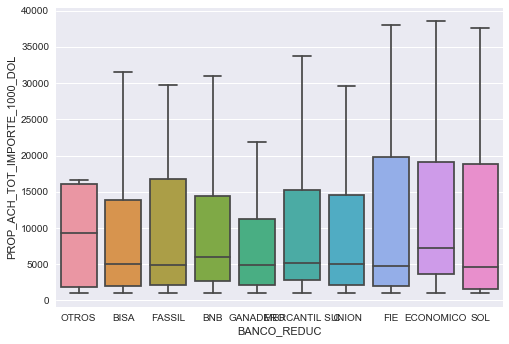

In [53]:
INDICADORES_MONTOS['BANCO_REDUC']=np.where(INDICADORES_MONTOS['PROP_ACH_BANCO_DESTINO_1000_DOL']=='BANCO NACIONAL DE BOLIVIA', 'BNB',
np.where(INDICADORES_MONTOS['PROP_ACH_BANCO_DESTINO_1000_DOL']=='BANCO BISA','BISA',
np.where(INDICADORES_MONTOS['PROP_ACH_BANCO_DESTINO_1000_DOL']=='BANCO MERCANTIL','MERCANTIL S.C',
np.where(INDICADORES_MONTOS['PROP_ACH_BANCO_DESTINO_1000_DOL']=='BANCO UNION','UNION',
np.where(INDICADORES_MONTOS['PROP_ACH_BANCO_DESTINO_1000_DOL']=='BANCO FASSIL  S.A.','FASSIL',
np.where(INDICADORES_MONTOS['PROP_ACH_BANCO_DESTINO_1000_DOL']=='BANCO GANADERO','GANADERO',
np.where(INDICADORES_MONTOS['PROP_ACH_BANCO_DESTINO_1000_DOL']=='BANCO ECONOMICO','ECONOMICO',
np.where(INDICADORES_MONTOS['PROP_ACH_BANCO_DESTINO_1000_DOL']=='BANCO FIE S.A.','FIE',
np.where(INDICADORES_MONTOS['PROP_ACH_BANCO_DESTINO_1000_DOL']=='BANCO SOL','SOL',         
         'OTROS')))))))))
sns.boxplot(x='BANCO_REDUC',y='PROP_ACH_TOT_IMPORTE_1000_DOL',data=INDICADORES_MONTOS,showfliers=False)
plt.show()

In [56]:
(INDICADORES_MONTOS['PROP_ACH_TOT_IMPORTE_1000_DOL']/INDICADORES_MONTOS['PROP_ACH_TOT_IMPORTE']).mean()

63.1031067127512

In [58]:
INDICADORES_MONTOS.to_excel('indicadores.xlsx',index=False)

BANCO_REDUC
OTROS             2
SOL               5
FIE               7
ECONOMICO        14
GANADERO         21
FASSIL           22
BISA             44
UNION            59
MERCANTIL S.C    79
BNB              86
Name: PROP_ACH_FLG_BANCO_DEST_1000_IGUAL_BANCO_GEN, dtype: int32
                                                                                                  
                                                                                                  
BANCO_REDUC
OTROS              8
FIE               13
SOL               22
ECONOMICO         28
FASSIL            57
GANADERO          61
BISA              74
UNION             97
BNB              143
MERCANTIL S.C    155
Name: DWH_UNIV_ID, dtype: int64
                                                                                                  
                                                                                                  


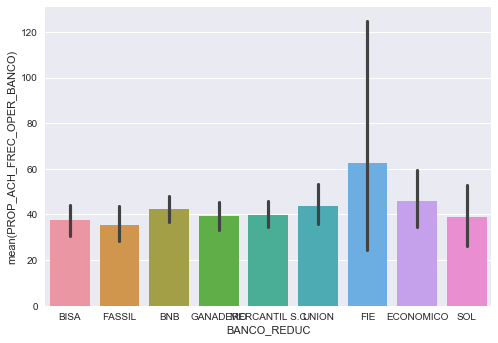

None


In [82]:
# Grafica del banco reduccion
print(INDICADORES_MONTOS[INDICADORES_MONTOS['PROP_ACH_FREC_OPER_BANCO_1000_dol']>1].groupby('BANCO_REDUC')['PROP_ACH_FLG_BANCO_DEST_1000_IGUAL_BANCO_GEN'].sum().sort_values())

print("                                                                                                  ")
print("==================================================================================================")
print("                                                                                                  ")

print(INDICADORES_MONTOS[INDICADORES_MONTOS['PROP_ACH_FREC_OPER_BANCO_1000_dol']>1].groupby('BANCO_REDUC')['DWH_UNIV_ID'].nunique().sort_values())

print("                                                                                                  ")
print("==================================================================================================")
print("                                                                                                  ")


sns.barplot(x="BANCO_REDUC", y="PROP_ACH_FREC_OPER_BANCO", data=INDICADORES_MONTOS[INDICADORES_MONTOS['BANCO_REDUC']!='OTROS'])
print(plt.show())

In [84]:
INDICADORES_MONTOS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2783 entries, 0 to 2782
Data columns (total 19 columns):
DWH_UNIV_ID                                     2783 non-null object
PERIODO_VIG                                     2783 non-null object
PROP_ACH_AVG_IMPORTE                            2783 non-null float64
PROP_ACH_MED_IMPORTE                            2783 non-null float64
PROP_ACH_STP_IMPORTE                            2580 non-null float64
PROP_ACH_TOT_IMPORTE                            2783 non-null float64
PROP_FREC_OPER                                  2783 non-null int64
PROP_ACH_FREC_OPER_BANCO                        2783 non-null int64
PROP_ACH_BANCO_DESTINO                          2783 non-null object
PROP_ACH_AVG_IMPORTE_1000_DOL                   1099 non-null float64
PROP_ACH_MED_IMPORTE_1000_DOL                   1099 non-null float64
PROP_ACH_STP_IMPORTE_1000_DOL                   658 non-null float64
PROP_ACH_TOT_IMPORTE_1000_DOL                   1099 non-null

In [ ]:
PROP_ACH_APOYO